In [11]:
# import statements
import pandas as pd
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen
import os
import spacy
import re
import string
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# Feature Engineering
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ML Models: Niave Bayes and SVM Classifiers
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# model evaluations
import matplotlib.pyplot as plt
import numpy as np 
from numpy import loadtxt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

### updates

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json
import time
import csv

ModuleNotFoundError: No module named 'tweepy'

In [ ]:
# download the training data from Sentiment140
zipurl = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall()

In [8]:
train = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                    header = None,
                    names = ['score', 'id', 'date', 'query', 'user', 'tweet'],
                    encoding='latin-1')
print(train.head())

   score          id                          date     query             user  \
0      0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3      0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4      0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                               tweet  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


In [9]:
# extract the information that we want
data_train = train[['score', 'tweet']]
print(data_train.head)

<bound method NDFrame.head of          score                                              tweet
0            0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1            0  is upset that he can't update his Facebook by ...
2            0  @Kenichan I dived many times for the ball. Man...
3            0    my whole body feels itchy and like its on fire 
4            0  @nationwideclass no, it's not behaving at all....
...        ...                                                ...
1599995      4  Just woke up. Having no school is the best fee...
1599996      4  TheWDB.com - Very cool to hear old Walt interv...
1599997      4  Are you ready for your MoJo Makeover? Ask me f...
1599998      4  Happy 38th Birthday to my boo of alll time!!! ...
1599999      4  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]>


In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
sentencizer = nlp.add_pipe("sentencizer")

def tweet_processing(comment):
    
    modComm = comment
    
    # Remove HTML special entities (e.g. &amp;)
    modComm = re.sub(r'\&\w*;', '', modComm)
    # Convert @username to AT_USER
    modComm = re.sub('@[^\s]+','',modComm)
    # Remove tickers
    modComm = re.sub(r'\$\w*', '', modComm)
    # To lowercase
    modComm = modComm.lower()
    # Remove hyperlinks
    modComm = re.sub(r'https?:\/\/.*\/\w*', '', modComm)
    # Remove hashtags
    modComm = re.sub(r'#\w*', '', modComm)
    # Remove whitespace (including new line characters)
    modComm = re.sub(r'\s\s+', ' ', modComm)
    # Remove single space remaining at the front of the tweet.
    modComm = modComm.lstrip(' ') 
    
    return modComm

def text_processing(tweet):
    
     # Check characters to see if they are in punctuation
    nopunc = [char for char in list(tweet) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]
    
# Lexicon normalisation with Stemming 
def stemming(tokens):
    """
    Takes in a string of text, then performs the following:
    1. Replace words for its root based on orter Stemmer rule.
    2. Returns normalised text
    """
    stemmer = PorterStemmer()
    x = [stemmer.stem(w) for w in tokens]
    
    return ' '.join(x)

In [28]:
mat = []
for i in range(0, len(data_train), 1):
    comment = stemming(text_processing(tweet_processing(data_train['tweet'][i])))
    mat.append([data_train['score'][i], comment])

In [33]:
print(len(mat))
print(len(mat[0]))
print(len(mat[1]))
print(mat[0:10])

1600000
2
2
[[0, 'awww that bummer shoulda got david carr third day'], [0, 'upset cant updat facebook text might cri result school today also blah'], [0, 'dive mani time ball manag save 50 rest go bound'], [0, 'whole bodi feel itchi like fire'], [0, 'behav im mad cant see'], [0, 'whole crew'], [0, 'need hug'], [0, 'hey long time see ye rain bit bit lol im fine thank how'], [0, 'nope didnt'], [0, 'que muera']]


In [36]:
mat = pd.DataFrame(mat, columns=['score', 'tokens'])

In [37]:
mat.to_csv('cleaned_train_data.csv', index=False)

In [190]:
mat = pd.read_csv('cleaned_train_data.csv')

In [191]:
mat.dropna(subset=['tokens'], inplace=True)

In [192]:
mat.head()

,score,tokens
0,0,awww that bummer shoulda got david carr third day
1,0,upset cant updat facebook text might cri resul...
2,0,dive mani time ball manag save 50 rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav im mad cant see


In [193]:
groups = mat.groupby(mat.score)
mat_0 = groups.get_group(0)
mat_4 = groups.get_group(4)
mat_0 = mat_0.sample(frac=0.03)
mat_4 = mat_4.sample(frac=0.03)

In [194]:
mat = [mat_0, mat_4]
mat = pd.concat(mat)

In [195]:
print(len(mat))

47780


In [196]:
analyser = SentimentIntensityAnalyzer()

def polarity_scores_all(tweet):
  '''
  Takes string of text to:
  1. Gets sentiment metrics
  2. Returns negative, neutral, positive 
  and compound scores as lists.
  '''
  neg, neu, pos, compound = [], [], [], []
  analyser = SentimentIntensityAnalyzer()
  
  for text in tweet:
    dict_ = analyser.polarity_scores(text)
    neg.append(dict_['neg'])
    neu.append(dict_['neu'])
    pos.append(dict_['pos'])
    compound.append(dict_['compound'])
  
  return neg, neu, pos, compound

In [197]:
all_scores = polarity_scores_all(mat.tokens.values)
mat['neg_scores'] = all_scores[0]
mat['neu_scores'] = all_scores[1]
mat['pos_scores'] = all_scores[2]
mat['compound_scores'] = all_scores[3]

In [198]:
mat.head(4)

,score,tokens,neg_scores,neu_scores,pos_scores,compound_scores
44590,0,cant tell u point becom malici packet sniffer etc,0.000,1.000,0.000,0.0000
467497,0,damn dad watch news,0.474,0.526,0.000,-0.4019
156258,0,sit beer pong tabl bc lost,0.315,0.685,0.000,-0.3182
370410,0,im realli miss grandeur 3632chitucki,0.200,0.375,0.425,0.4215


In [47]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tony_niu/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [199]:
# To transform pos tags to readable tags
pos_family = {  
    'NOUN' : ['NN','NNS','NNP'], # Removed 'NNPS'
    'PRON' : ['PRP','PRP$','WP','WP$'],
    'VERB' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'ADJ' :  ['JJ','JJR','JJS'],
    'ADV' : ['RB','RBR','RBS','WRB']
}

def count_pos_tag(tweets):
    '''
    Takes string of text to:
    1. Processes text and attaches POS tags
    2. Input the dictionary of POS tags into a Counter.
    3. Returns list of POS tags with occurrence number.
    '''
    total_count = []
    for s in tweets:
        partial_count = {}
        s = s.split()
        count_pos = Counter(dict(nltk.pos_tag(s)).values())
        
        for item, value in count_pos.items():
            partial_count[item] = partial_count.get(item, 0) + 1
            
        total_count.append(partial_count)
        
    return total_count

In [200]:
# Retrieve POS tags with occurrence 
total_count = count_pos_tag(mat.tokens.values)

# As dataframe 
pos_df = pd.DataFrame(total_count)

# Remove unwanted characters
pos_df = pos_df.drop(['$', 'IN'], axis = 1) #drop '$' if needed

# Inspection
pos_df.columns

Index(['NN', 'JJ', 'VBD', 'VBP', 'CD', 'DT', 'NNS', 'VB', 'VBN', 'RB', 'PRP',
       'VBZ', 'JJS', 'MD', 'WRB', 'RBR', 'PRP$', 'JJR', 'VBG', 'NNP', 'RP',
       'WP', 'UH', 'EX', 'WDT', 'FW', 'CC', 'TO', 'RBS', 'SYM', 'WP$', 'PDT',
       'LS', ''''],
      dtype='object')

In [201]:
# Change tags to readable tags

pos_df['NOUN'] = pos_df[pos_family['NOUN']].sum(axis=1)
pos_df['PRON'] = pos_df[pos_family['PRON']].sum(axis=1)
pos_df['VERB'] = pos_df[pos_family['VERB']].sum(axis=1)
pos_df['ADJ'] = pos_df[pos_family['ADJ']].sum(axis=1)
pos_df['ADV'] = pos_df[pos_family['ADV']].sum(axis=1)

pos_df = pos_df[['NOUN', 'PRON', 'VERB', 'ADJ', 'ADV']]

In [202]:
# Add to end of original data set as new features 
mat = pd.concat([mat, pos_df], axis = 1)

# Deal with NaN
mat = mat.fillna(value=0.0)

#train = train.fillna(value=0.0)
mat.shape

# Remove duplicates 
mat.drop_duplicates(subset=['tokens'], inplace=True)

In [203]:
# Check new features
mat.info()

mat.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46384 entries, 0 to 1599996
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   score            46384 non-null  float64
 1   tokens           46384 non-null  object 
 2   neg_scores       46384 non-null  float64
 3   neu_scores       46384 non-null  float64
 4   pos_scores       46384 non-null  float64
 5   compound_scores  46384 non-null  float64
 6   NOUN             46384 non-null  float64
 7   PRON             46384 non-null  float64
 8   VERB             46384 non-null  float64
 9   ADJ              46384 non-null  float64
 10  ADV              46384 non-null  float64
dtypes: float64(10), object(1)
memory usage: 4.2+ MB


,score,tokens,neg_scores,neu_scores,pos_scores,compound_scores,NOUN,PRON,VERB,ADJ,ADV
0,0.0,0,0.000,0.000,0.000,0.0000,1.0,0.0,0.0,1.0,0.0
32,0.0,thought sleep option tomorrow realiz evalu mor...,0.000,1.000,0.000,0.0000,1.0,0.0,1.0,1.0,0.0
62,0.0,life cool,0.000,0.303,0.697,0.3182,1.0,0.0,1.0,0.0,0.0
111,0.0,im sooo sad kill kutner hous whyyyyyyyy,0.609,0.391,0.000,-0.8316,1.0,0.0,1.0,1.0,0.0
119,0.0,aaw miss ya im leav bh tomorrow morn think aww...,0.096,0.904,0.000,-0.1531,1.0,0.0,0.0,0.0,0.0


In [204]:
mat.to_csv('feat_eng_train_data.csv', index = False)

In [124]:
# Define keys
consumer_key= 'zj2ui3B0C1fTC8UvOxzhRZUK0'
consumer_secret= 'xsl4c4MCM1HHyzK1aj1oVfmIM4CGmvjIZEeLBHB5WKdZeAa0MH'
access_token= '2781369394-xYcT5pQLGJ7HS6f55uZDzFOd0fjnDxk1xY6RKV6'
access_token_secret= 'lYmgK4j89xeGJ70oHpeoLB7VPYEuZWnlo2mrs6E3lkfkK'

# bearer token = AAAAAAAAAAAAAAAAAAAAAKVBOQEAAAAAHAxe6l8VibnmeNnfqKtvv%2FfNDWA%3D2WcVo6IJKC6b3mWhYgMf5E9buB7KNLE4CHku89xfmlRn1MU1T4

In [135]:
# Authentication
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [136]:
# Post a tweet from Python
api.update_status("Test tweet from Python Tweepy 2")
# Your tweet has been posted!

Status(_api=<tweepy.api.API object at 0x7f9178844940>, _json={'created_at': 'Mon Apr 05 20:57:27 +0000 2021', 'id': 1379176379418296327, 'id_str': '1379176379418296327', 'text': 'Test tweet from Python Tweepy 2', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}, 'source': '', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 2781369394, 'id_str': '2781369394', 'name': 'Tony Niu', 'screen_name': 'tonyniu227', 'location': 'Toronto', 'description': 'Singer-Songwriter', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 130, 'friends_count': 393, 'listed_count': 2, 'created_at': 'Tue Sep 23 14:40:47 +0000 2014', 'favourites_count': 10897, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': False, 'statuses_count': 800, 'lang': None, 'contributors_enabled':

In [138]:
# Define the search term and the date_since date as variables
start_time = time.time()

max_id = -1000000000000000000000000000000000
tweetsPerQry = 100  # this is the max the API permits
search_words = '(capitol OR "capitol storm" OR democrat OR republican OR riot)'
date_since = "2021-01-06"

# Collect tweets
# open/create a csv file to append data
csvFile = open(search_words + '_data2.csv', 'w', encoding='utf-8')

# use csv Writer
csvWriter = csv.writer(csvFile)

# get data from twitter
tweet_num = 0
for tweet in tw.Cursor(api.search,q=search_words + ' -RT',count=tweetsPerQry,lang="en", 
                       since=date_since, max_id=str(max_id - 1)).items(9999999999):
    try:
        # not entirely necessary but you can inspect what is being written to file
        print ('tweet number: {}'.format(tweet_num), tweet.text, tweet.place.full_name)
        # write data to csv
        csvWriter.writerow([tweet.created_at,
                            tweet.user.location,
                            tweet.user.followers_count,
                            tweet.user.friends_count,
                            tweet.text,
                            tweet.place.bounding_box.coordinates,
                            tweet.place.full_name,
                            tweet.place.country,
                            tweet.place.country_code,
                            tweet.place.place_type])
        tweet_num += 1
    except Exception:
        pass

print("--- %s seconds ---" % (time.time() - start_time))

tweet number: 0 #DeSantisCovidCoverUp #DeSantisFailedFlorida #DeSantisForPrison He’s a TYPICAL REPUBLICAN L: all about the Benjamin… https://t.co/R0w9eimd6i Dallas, TX
tweet number: 1 While easy to  label it complex it all starts in steps with the first one being to do something. Second restore  pu… https://t.co/3WLYaW3t5G Pasadena, CA
tweet number: 2 People boycotting Publix, a founding family gave $300,000 Trump rally preceded Capitol riot,now Publix totals R clo… https://t.co/wLy4aHiE2s Boca Raton, FL
tweet number: 3 @chrisgeidner Wow a Republican with *a little bit* of a conscience Staten Island, NY
tweet number: 4 She a Republican. "I'm fighting the libruhl media!!1" is a fundraising pitch https://t.co/m3XzDY38Y3 Durham, NC
tweet number: 5 I’m not sure how DEBO differentiates between greed under democrats vs. greed under trump. Obviously DEBO is okay wi… https://t.co/rzcuTssczY Escazu, Costa Rica
tweet number: 6 @BZman543 @LWMillar @rahmani_khatera @ClayTravis At the time, they di

TweepError: Failed to send request: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [139]:
# create column names
col_names=['date','user_loc','followers','friends','message','bbox_coords',\
           'full_name','country','country_code','place_type']

# read csv
df_twtr = pd.read_csv('(capitol OR "capitol storm" OR democrat OR republican OR riot)_data2.csv', names=col_names)

# check head
df_twtr.head()

,date,user_loc,followers,friends,message,bbox_coords,full_name,country,country_code,place_type
0,2021-04-05 21:04:07,"Dallas, TX",286,839,#DeSantisCovidCoverUp #DeSantisFailedFlorida #...,"[[[-96.977527, 32.620678], [-96.54598, 32.6206...","Dallas, TX",United States,US,city
1,2021-04-05 20:59:56,"Pasadena, CA",69,221,While easy to label it complex it all starts ...,"[[[-118.198346, 34.117025], [-118.065582, 34.1...","Pasadena, CA",United States,US,city
2,2021-04-05 20:59:23,"iPhone: 26.428280,-80.122902",67482,82604,"People boycotting Publix, a founding family ga...","[[[-80.2039913, 26.320692], [-80.065981, 26.32...","Boca Raton, FL",United States,US,city
3,2021-04-05 20:55:27,"Staten Island, NY",20,122,@chrisgeidner Wow a Republican with *a little ...,"[[[-74.255641, 40.495865], [-74.052253, 40.495...","Staten Island, NY",United States,US,city
4,2021-04-05 20:54:09,Durham NC,129592,984,"She a Republican. ""I'm fighting the libruhl me...","[[[-79.0075886, 35.866334], [-78.783292, 35.86...","Durham, NC",United States,US,city


In [140]:
# Sort dataframe by date column
df_twtr['date'] = pd.to_datetime(df_twtr['date'])
df_twtr = df_twtr.sort_values(by='date',ascending=True)
df_twtr = df_twtr.reset_index().drop('index',axis=1)
df_twtr.head()

,date,user_loc,followers,friends,message,bbox_coords,full_name,country,country_code,place_type
0,2021-04-05 16:40:27,NaN,240,1745,@DoctorHenryCT What if republican districts ha...,"[[[-119.675838, 34.415858], [-119.575876, 34.4...","Montecito, CA",United States,US,city
1,2021-04-05 16:41:41,"California, USA",82,570,Do you remember Rathergate on 60 minutes that ...,"[[[-122.0327579, 38.308561], [-121.911095, 38....","Vacaville, CA",United States,US,city
2,2021-04-05 16:42:04,"Akron, OH",92,1122,@StephMillerShow @Thom_Hartmann @RandiRhodes @...,"[[[-81.628444, 40.995137], [-81.405059, 40.995...","Akron, OH",United States,US,city
3,2021-04-05 16:42:16,NaN,167,445,"@justinbaragona Toobin was a journalist, there...","[[[-73.177371, 41.367979], [-73.083156, 41.367...","Oxford, CT",United States,US,city
4,2021-04-05 16:42:38,"Washington, DC",112,305,Now we’re talking. This is the stuff that make...,"[[[-77.119401, 38.801826], [-76.909396, 38.801...","Washington, DC",United States,US,city


In [141]:
df_twtr = df_twtr.drop(['bbox_coords','place_type','followers','friends'],axis=1)
df_twtr.head()

,date,user_loc,message,full_name,country,country_code
0,2021-04-05 16:40:27,NaN,@DoctorHenryCT What if republican districts ha...,"Montecito, CA",United States,US
1,2021-04-05 16:41:41,"California, USA",Do you remember Rathergate on 60 minutes that ...,"Vacaville, CA",United States,US
2,2021-04-05 16:42:04,"Akron, OH",@StephMillerShow @Thom_Hartmann @RandiRhodes @...,"Akron, OH",United States,US
3,2021-04-05 16:42:16,NaN,"@justinbaragona Toobin was a journalist, there...","Oxford, CT",United States,US
4,2021-04-05 16:42:38,"Washington, DC",Now we’re talking. This is the stuff that make...,"Washington, DC",United States,US


In [142]:
# Save as csv
df_twtr.to_csv('df_twtr.csv')

In [143]:
# Load back in
test = pd.read_csv('df_twtr.csv')

In [144]:
test.shape

(267, 7)

In [5]:
# load data
training = pd.read_csv('feat_eng_train_data.csv')

# remove rows with none values
training = training.dropna(0, 'any')

# Features TODO: correct feature names
features = ['tokens', 'neu_scores', 'neg_scores', 'compound_scores', 'pos_scores']
label = ['score']

# Saving features and label data in X and y for train-test split
X = training[[col for col in training.columns if col in features]]
y = training[label]

# splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [6]:
# Helper functions from gracecarrillo

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
# Pipeline to convert tweets to a matrix of TF-IDF features.
tfidf = Pipeline([
                ('selector', TextSelector(key='tokens')),
                ('tfidf', TfidfVectorizer())
            ])

# Pipeline to convert tweets to a matrix of token counts
countvect = Pipeline([
                ('selector', TextSelector(key='tokens')),
                ('countvect', CountVectorizer())
            ])

# Applying tfidf anf countvec to features
neu_scores =  Pipeline([
                ('selector', NumberSelector(key='neu_scores')),
                ('minmax', MinMaxScaler())
            ])
neg_scores =  Pipeline([
                ('selector', NumberSelector(key='neg_scores')),
                ('minmax', MinMaxScaler())
            ])
pos_scores =  Pipeline([
                ('selector', NumberSelector(key='pos_scores')),
                ('minmax', MinMaxScaler())
            ])

compound_scores =  Pipeline([
                ('selector', NumberSelector(key='compound_scores')),
                ('minmax', MinMaxScaler())
            ])

In [7]:
# defining different sets of text processors
def features_union(textProcessor):
    return FeatureUnion([('tokens', textProcessor),
                      ('neu_scores', neu_scores),
                      ('neg_scores', neg_scores),
                      ('pos_scores', pos_scores),
                      ('compound_scores', compound_scores)])
# Normalise labels
le = LabelEncoder().fit(y_train.values.ravel()) #if error occurs, try removing or adding values before ravel

y_train = le.transform(y_train.values.ravel())
y_test = le.transform(y_test.values.ravel())

In [8]:
# Naive-Bayes Classifier

# instantiate classifier
clf = MultinomialNB()

# combine features
features_count = features_union(countvect)

# define pipeline object 
nb_pipeline = Pipeline([('features', features_count),
                       ('nb', clf)])

# Fit classifier
nb_pipeline.fit(X_train, y_train)

# score
nb_pipeline.score(X_test, y_test)

0.7382150043115838

In [9]:
# SVM Classifier

# instantiate classifier
svm = LinearSVC()

#  combine features
features_tfidf = features_union(tfidf)

# define pipeline object
svm_pipeline = Pipeline([('features', features_tfidf),
                       ('svm', svm)])

# Fit classifier
svm_pipeline.fit(X_train, y_train.ravel())

# score
svm_pipeline.score(X_test, y_test.ravel())

0.7342627191721759

In [ ]:
import time

# cross valiadation for Naive-Bayes Classifier

# instantiate pipeline object
nb_pipeline = Pipeline([('feats', features_tfidf),  ('clf', MultinomialNB())])

# parameter grid (3x3x2x2x3x3x2) combinations
parameters = {
    'feats__tokens__tfidf__max_df': (0.5, 0.75, 1.0),
    'feats__tokens__tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)), 
    'feats__tokens__tfidf__use_idf': (False, True),
    'feats__tokens__tfidf__binary':(False, True),
    'feats__tokens__tfidf__binary':('l1', 'l2', None),
    'clf__alpha': (1.0, 5.0, 10.0),
    'clf__fit_prior': (True, False),     
}

# instantiate GridSearchCV object with pipeline and parameters with 3-folds cross-validation
nb_grid = GridSearchCV(nb_pipeline, parameters, cv=3)

# start time 
nb_start = time.time()

# Fit 
nb_grid.fit(X_train, y_train)

# end time 
nb_end = time.time()
# print(f"Time taken to run: {round((nb_end - nb_start)/60,1)} minutes") TOTAL: ~25

# Check score
print(nb_grid.score(X_test, y_test))

nb_cv_results = pd.DataFrame(nb_grid.cv_results_)

In [ ]:
# cross validation for SVM Classifier

# instantiate pipeline
svm_count_pipeline = Pipeline([('feats', features_count),  ('clf', LinearSVC())])

# parameter grid (3x3x2x3x7x2) combinations
parameters = {
    'feats__tokens__countvect__max_df': (0.5, 0.75, 1.0),
    'feats__tokens__countvect__ngram_range': ((1, 1), (1, 2), (2, 2)), 
    #'feats__tokens__countvect__use_idf': (False, True),
    'clf__loss': ('hinge', 'squared_hinge'),
    'clf__C': (0.1, 0.5, 0.6, 1, 4, 5, 10, 100),
    'clf__class_weight': (None, 'balanced')                                    
}

# instantiate GridSearchCV object with pipeline and parameters with 3-folds cross-validation
svm_grid = GridSearchCV(svm_count_pipeline, parameters, cv=3)

# start time 
svm_start = time.time()

# fit
svm_grid.fit(X_train, y_train)

# end time 
svm_end = time.time()
# print(f"Time taken to run: {round((svm_end - svm_start)/60,1)} minutes") TOTAL: ~50

# score
svm_grid.score(X_test, y_test)

svm_cv_results = pd.DataFrame(svm_grid.cv_results_)

In [ ]:
# save best model per each classifier
joblib.dump(nb_grid, "twitter_sentiment_naivebayes.pkl")
joblib.dump(svm_grid, "twitter_sentiment_svm.pkl")

# Get and save predictions from best models above

# Naive Bayes
y_preds_nb = nb_grid.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('y_predsNB.npy', y_preds_nb)

# Support Vector Machine
y_preds_svm = svm_grid.predict(X_test)
# Save predictions for evaluation as numpy arrays
np.save('y_predsSVM.npy', y_preds_svm)

# Save test data for evaluation in the next notebook
np.save('y_test.npy', y_test)

In [12]:
# Set up labels
labels = LabelEncoder().fit(['negative', 'positive'])

# Import Naive-Bayes and SVM learning model predictions
y_pred_nb = np.load('y_predsNB.npy')
y_pred_svm = np.load('y_predsSVM.npy')

# Import ML test data
y_test = np.load('y_test.npy')

In [13]:
# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

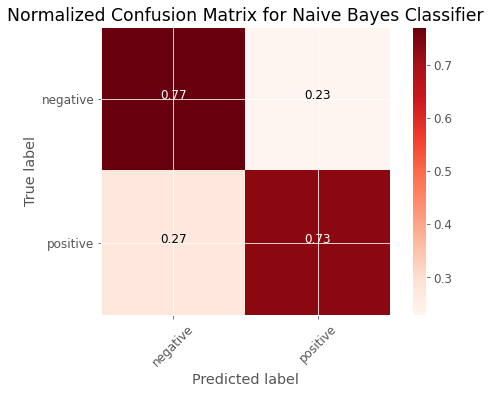

In [14]:
# Naive Bayes Classifier

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_nb)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized Confusion Matrix for Naive Bayes Classifier')

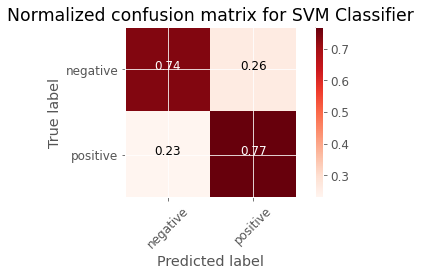

In [15]:
# Support Vector Machine Classifier

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig.add_subplot(3,3,2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized confusion matrix for SVM Classifier')

In [16]:
# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  df_report = pd.DataFrame(report).transpose()
  #round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']

  return df_report

In [17]:
# Classification reports for ML models

# Naive Bayes Classifier
report_nb = classification_report_asdf(y_test, y_pred_nb)

# SVM Classifier
report_svm = classification_report_asdf(y_test, y_pred_svm)

#Add reports together 
SML_dfs = [report_nb, report_svm]

SML_dfs_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in SML_dfs],
    keys=['Naive Bayes Classifier', 'SVM Classifier'],
    axis=1
)

# Show reports
SML_dfs_combined

Naive Bayes Classifier                         SVM Classifier  \
                          precision recall f1-score support      precision   
0                              0.74   0.77     0.76    6948           0.76   
1                              0.76   0.73     0.75    6968           0.75   
accuracy                       0.75   0.75     0.75   13916           0.75   
macro avg                      0.75   0.75     0.75   13916           0.75   
weighted avg                   0.75   0.75     0.75   13916           0.75   

                                      
             recall f1-score support  
0              0.74     0.75    6948  
1              0.77     0.76    6968  
accuracy       0.75     0.75   13916  
macro avg      0.75     0.75   13916  
weighted avg   0.75     0.75   13916

In [60]:
file_path = 'training.1600000.processed.noemoticon.csv'
os.remove(file_path)
file_path = 'testdata.manual.2009.06.14.csv'
os.remove(file_path)